In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import romb
from tqdm import tqdm
from scipy.interpolate import interp1d
import h5py
from scipy import stats
import pandas as pd
import matplotlib as mpl
from astropy.cosmology import Planck18 as COSMO
from astropy.constants import c
import astropy.units as u


SPEED_OF_LIGHT_KMS = c.to('km/s').value


def uniform_comoving_prior(z):
    '''Proportional to uniform in comoving volume prior.'''
    z = np.atleast_1d(z)
    chi = COSMO.comoving_distance(z).value         # Mpc
    H_z = COSMO.H(z).value                         # km/s/Mpc
    dchi_dz = SPEED_OF_LIGHT_KMS / H_z             # Mpc
    p = (chi**2 * dchi_dz)
    return p


def make_nice_plots():
    SMALL_SIZE = 10 * 2 
    MEDIUM_SIZE = 12 * 2
    BIGGER_SIZE = 14 * 2

    plt.rc('text', usetex=True)
    plt.rc('axes', titlesize=SMALL_SIZE)
    plt.rc('axes', labelsize=MEDIUM_SIZE)
    plt.rc('xtick', labelsize=SMALL_SIZE, direction='out')
    plt.rc('ytick', labelsize=SMALL_SIZE, direction='out')
    plt.rc('legend', fontsize=SMALL_SIZE)
    mpl.rcParams['axes.titlesize'] = BIGGER_SIZE
    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['mathtext.fontset'] = 'cm'
    mpl.rcParams['font.family'] = 'STIXgeneral'

    mpl.rcParams['figure.dpi'] = 100

    mpl.rcParams['xtick.minor.visible'] = True
    mpl.rcParams['ytick.minor.visible'] = True
    mpl.rcParams['xtick.top'] = True
    mpl.rcParams['ytick.right'] = True

    mpl.rcParams['xtick.major.size'] = 10
    mpl.rcParams['ytick.major.size'] = 10
    mpl.rcParams['xtick.minor.size'] = 4
    mpl.rcParams['ytick.minor.size'] = 4

    mpl.rcParams['xtick.major.width'] = 1.25
    mpl.rcParams['ytick.major.width'] = 1.25
    mpl.rcParams['xtick.minor.width'] = 1
    mpl.rcParams['ytick.minor.width'] = 1

make_nice_plots()

COLORS = ['orangered', 'navy', 'teal', 'goldenrod', 'hotpink', 'indigo', 'crimson']


-21.06422475388272


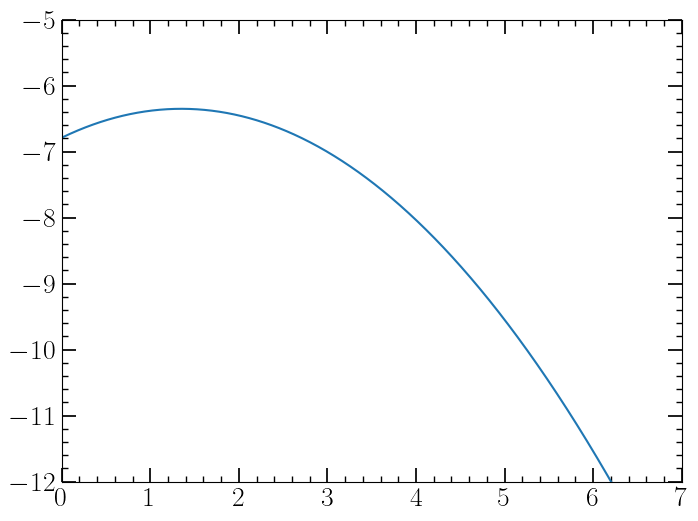

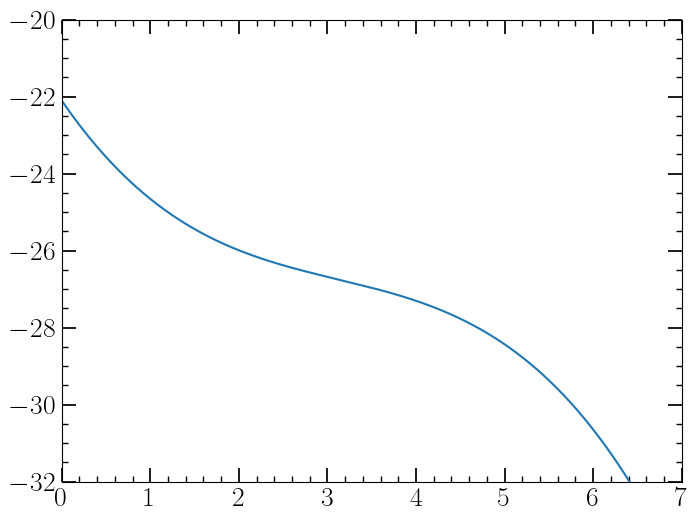

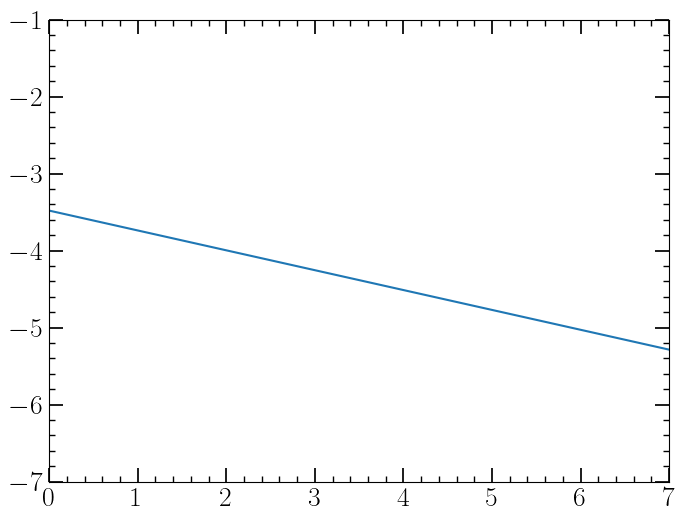

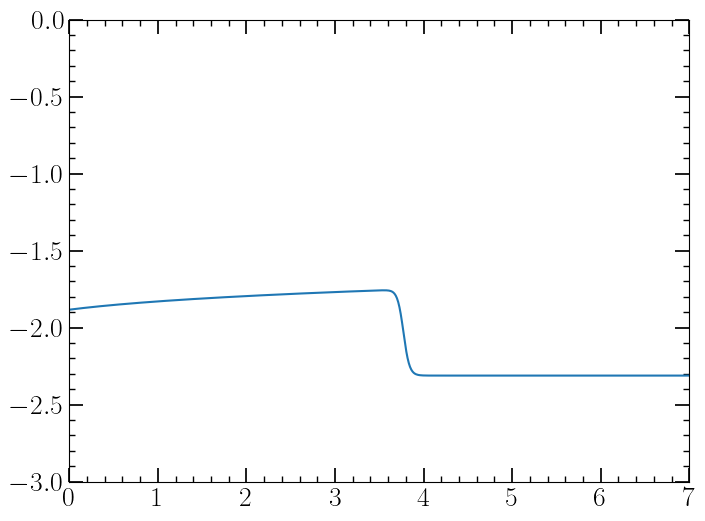

In [18]:
from scipy.special import chebyt

COEFFICIENTS = {
    0: np.array([
        [-7.798, +0.145, -0.157],  # c0,0
        [ 1.128, +0.085, -0.081],  # c0,1
        [-0.120, +0.005, -0.006],  # c0,2
    ]),
    
    1: np.array([
        [-17.163, +0.219, -0.226],   # c1,0
        [ -5.512, +0.127, -0.124],   # c1,1
        [  0.593, +0.011, -0.010],   # c1,2
        [ -0.024, +0.00035, -0.00039], # c1,3
    ]),
    
    2: np.array([
        [ -3.223, +0.127, -0.121],   # c2,0
        [ -0.258, +0.047, -0.051],   # c2,1
    ]),
    
    3: np.array([
        [ -2.312, +0.034, -0.032],   # c3,0
        [  0.559, +0.049, -0.045],   # c3,1
        [  3.773, +0.017, -0.016],   # c3,2
        [141.884, +31.521, -3.832],  # c3,3
        [ -0.171, +0.101, -0.116],   # c3,4
    ])
}


# def QLF(M, phi_star, M_star, alpha, beta):
#     """
#     M: absolute magnitude
#     phi_star: amplitude
#     M_star: break magnitude
#     alpha: bright-end slope
#     beta: faint-end slope
#     """
#     return phi_star / (10**(0.4 * (alpha + 1) * (M - M_star)) + 10**(0.4 * (beta + 1) * (M - M_star)))


def F(i, z):
    z = np.atleast_1d(z)
    x = 1 + z
    ci = COEFFICIENTS[i][:,0]
    
    if i != 3:
        Fi_x = np.zeros_like(z)
        for j, cij in enumerate(ci): 
            Fi_x += cij * chebyt(j)(x)
        return Fi_x
    
    elif i == 3:
        c30, c31, c32, c33, c34 = ci
        zeta = np.log10( x / (1 + c32) )
        return c30 + c31 / (10**(c33 * zeta) + 10**(c34 * zeta))
    
    else:
        print('boooooo')


def log10_phi_star_zevo(z):
    return F(0, z)


def M_star_zevo(z):
    return F(1, z)


def alpha_zevo(z):
    return F(2, z)


def beta_zevo(z):
    return F(3, z)


def log10addexp10(a, b):
    return np.maximum(a, b) + np.log10(1 + 10**(-abs(a - b)))


def log10_QLF(M, z):
    """
    M: absolute magnitude
    log10_phi_star: log base 10 of amplitude [mag^-1 cMpc^-3]
    M_star: break magnitude
    alpha: bright-end slope
    beta: faint-end slope
    """
    log10_phi_star = log10_phi_star_zevo(z)
    M_star = M_star_zevo(z)
    alpha = alpha_zevo(z)
    beta = beta_zevo(z)

    term1 = 0.4 * (alpha + 1) * (M - M_star)
    term2 = 0.4 * (beta + 1) * (M - M_star)
    return log10_phi_star - log10addexp10(term1, term2)


def L2M(log10_Lbol):
    """
    Convert bolometric luminosity in erg/s to absolute AB magnitude at 1450 Angstrom. We use the magnitude-dependention function (Eq. 9) of Runnoe et al. (2012).
    """
    log10_Liso = log10_Lbol - np.log10(0.75)  # Viewing angle correction
    log10_nuLnu1450 = (log10_Liso - 4.74) / 0.91
    log10_Lnu1450 = log10_nuLnu1450 - np.log10((1450 * u.Angstrom).to(u.Hz, equivalencies=u.spectral()).value)

    offset = 2.5 * np.log10( 4 * np.pi * ((10 * u.pc).to(u.cm).value)**2 ) - 48.60
    M_AB = lambda log10_Lnu: -2.5 * log10_Lnu + offset
    return M_AB(log10_Lnu1450)

print(L2M(45))

# def L2M(log10_Lbol):

#     log10_Liso = log10_Lbol - np.log10(0.75)  # Viewing angle correction
#     log10_L1450 = (log10_Liso - 4.74) / 0.91
#     L0 = 3.0128e35  # erg/s
#     return -2.5 * (log10_L1450 - np.log10(L0))

# print(L2M(45))


# def L2M(log10_Lbol):
#     # log10_Liso = log10_Lbol - np.log10(0.75)  # Viewing angle correction
#     # log10_L1450 = np.log10( (log10_Liso - 4.74) / 0.91 ) - np.log10(1450)
#     # log10_Liso = 0.91 * (log10_Lbol + np.log10(1450)) + 4.74
#     L0 = 3.0128e35  # erg/s
#     return -2.5 * (log10_Liso - np.log10(L0))
    

# print(L2M(45.5 - 7))

# z_eval = 0.72 # 0.31#
# plt.figure()
# # plt.plot(np.linspace(-30, 0, 1000), np.log10( QLF(np.linspace(-30, 0, 1000), phi_star=10**(-5.72), M_star=-21.30, alpha=-2.74, beta=-1.07) ), label='In bin')
# plt.plot(np.linspace(-30, 0, 1000), np.log10( QLF(np.linspace(-30, 0, 1000), phi_star=10**(-6.57), M_star=-24.21, alpha=-3.55, beta=-1.89) ), label='In bin')
# plt.plot(np.linspace(-30, 0, 1000), log10_QLF(np.linspace(-30, 0, 1000), z=z_eval), label='All z')
# plt.legend()
# plt.show()

z_ax = np.linspace(0, 7, 1000)
plt.figure(figsize=(8,6))
plt.plot(z_ax, log10_phi_star_zevo(z_ax))
plt.xlim(0, 7)
plt.ylim(-12, -5)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(z_ax, M_star_zevo(z_ax))
plt.xlim(0, 7)
plt.ylim(-32, -20)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(z_ax, alpha_zevo(z_ax))
plt.xlim(0, 7)
plt.ylim(-7, -1)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(z_ax, beta_zevo(z_ax))
plt.xlim(0, 7)
plt.ylim(-3, 0)
plt.show()


8it [00:00, 502.94it/s]
8it [00:00, 523.64it/s]
8it [00:00, 537.66it/s]
8it [00:00, 526.70it/s]
8it [00:00, 537.02it/s]
/tmp/ipykernel_31330/1771167652.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


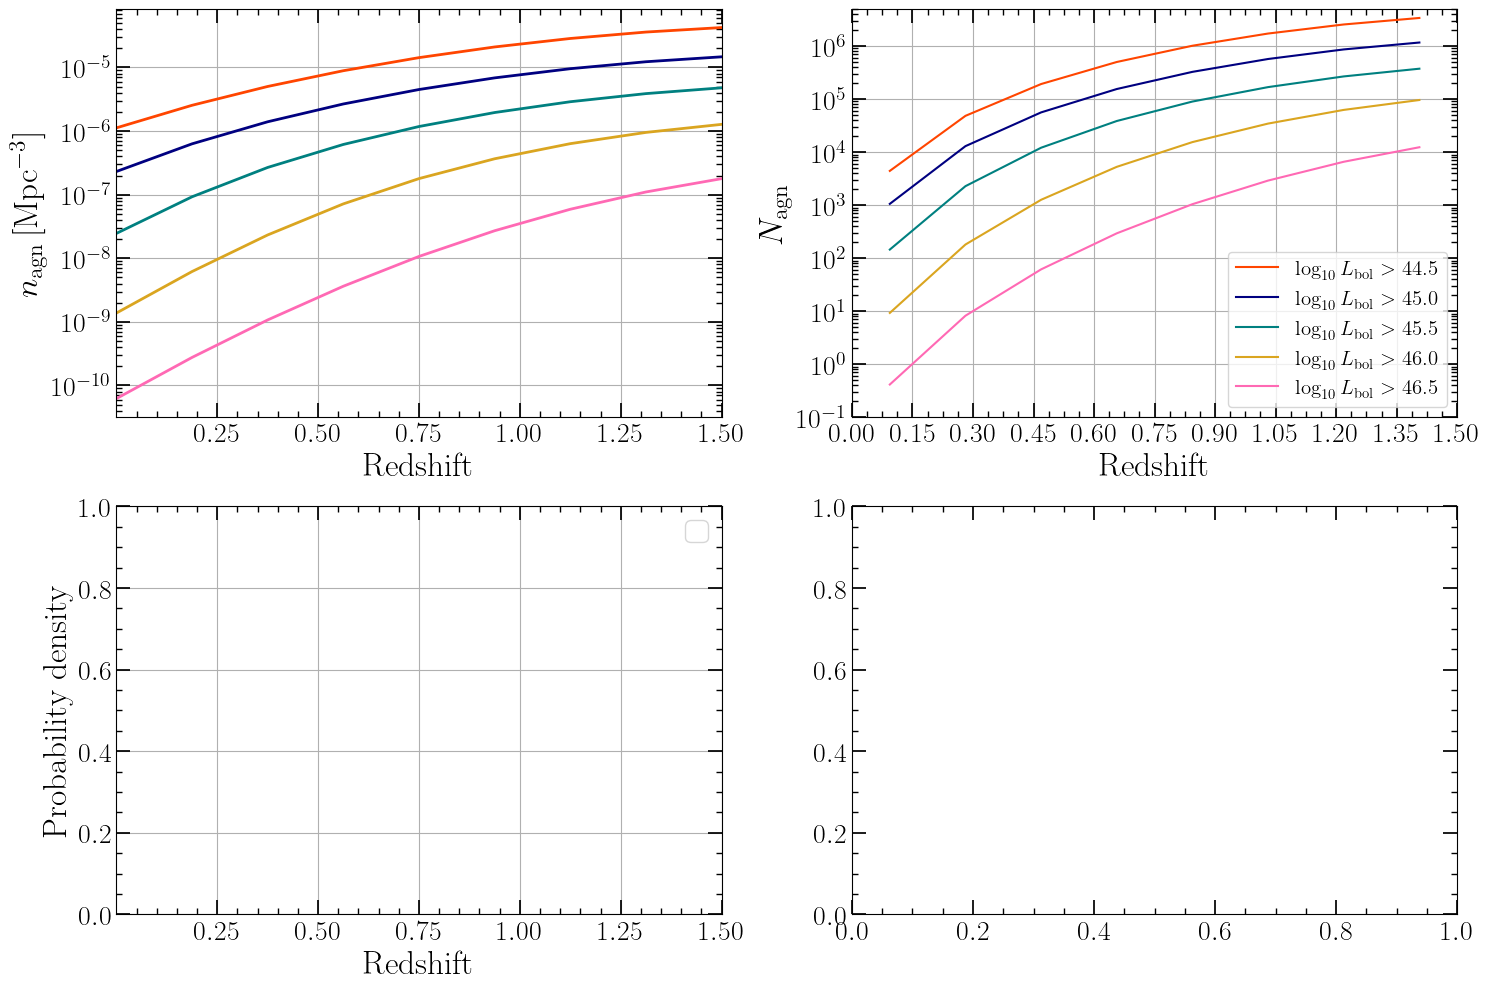

In [19]:
m_threshes = [-21, -24, -25.5, -27, 0]
L_threshes = [44.5, 45.0, 45.5, 46.0, 46.5]

# Either use these values or zmax = 1.5 and Nbins = 8 to reproduce Veronesi+25
zmin = 1e-4
zmax = 1.5  # 1.5
Nbins = 8  # 8
redshift_bin_edges = np.linspace(zmin, zmax, Nbins+1)  # romb() requires 2**N + 1 samples and edges is 1 more than bins
redshift_bin_centers = (redshift_bin_edges + np.roll(redshift_bin_edges, shift=1))[1:] / 2

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))

ax1.semilogy()
ax1.set_xlim(zmin, zmax)
# ax1.set_ylim(1e-10, 2e-4)
ax1.set_xlabel('Redshift')
ax1.set_ylabel(r'$n_{\rm agn} \, [\mathrm{Mpc^{-3}}]$')
ax1.grid()

ax2.grid()
ax2.semilogy()
ax2.set_xlim(zmin, zmax)
ax2.set_xlabel('Redshift')
ax2.set_ylabel(r'$N_{\rm agn}$')

ax3.grid()
ax3.set_xlim(zmin, zmax)
ax3.set_xlabel('Redshift')
ax3.set_ylabel('Probability density')
# ax3.plot(redshift_bin_centers, uniform_comoving_prior(redshift_bin_centers) / romb(uniform_comoving_prior(redshift_bin_centers), dx=np.diff(redshift_bin_centers)[0]), label='Uniform', color='black', linewidth=2)

for i, L_thresh in enumerate(L_threshes):

    # Step 1: Get number densities by integrating QLF over magnitude
    magthresh = L2M(L_thresh)
    # magthresh = m_threshes[i]  # Uncomment this if you want to reproduce Kulkarni+19 Fig. 7

    mag_integrate_axis = np.linspace(-50, magthresh, int(1024)+1)
    n_of_z = lambda z: romb(10**log10_QLF(mag_integrate_axis[:,np.newaxis], z=z[np.newaxis,:]), dx=np.diff(mag_integrate_axis)[0], axis=0)
    numdenses = n_of_z(redshift_bin_edges).flatten()
    ax1.plot(redshift_bin_edges, numdenses, color=COLORS[i], linewidth=2)

    # Step 2: Get redshift distribution by integrating QLF in redshift bins
    n_agn_in_zbin = np.zeros_like(redshift_bin_centers)
    for j, redshift_bin_center in tqdm( enumerate(redshift_bin_centers) ):
        zlow, zhigh = redshift_bin_edges[j], redshift_bin_edges[j+1]
        z_integrate_ax = np.linspace(zlow, zhigh, 128+1)

        numdens_in_bin = n_of_z(z_integrate_ax)
        n_agn_in_zbin[j] = 4 * np.pi * romb(numdens_in_bin * COSMO.differential_comoving_volume(z_integrate_ax).value, dx=np.diff(z_integrate_ax)[0])
    ax2.plot(redshift_bin_centers, n_agn_in_zbin, color=COLORS[i], label=r'$\log_{10} L_{\rm bol} >$ ' + str(L_thresh))

    # Step 3: Get redshift PDFs by normalizing
    # agn_redshift_pdf = n_agn_in_zbin / romb(n_agn_in_zbin, dx=np.diff(redshift_bin_centers)[0])
    # ax3.plot(redshift_bin_centers, agn_redshift_pdf, color=COLORS[i], linewidth=2)

ax2.legend(fontsize=15)
ax2.set_ylim(1e-1, 5e6)
ax2.set_xticks([0.0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2, 1.35, 1.5])
ax3.legend()
plt.tight_layout()
plt.show()


In [5]:
print(redshift_bin_centers)
print(redshift_bin_edges)

[0.08342778 0.25008333 0.41673889 0.58339444 0.75005    0.91670556
 1.08336111 1.25001667 1.41667222]
[1.00000000e-04 1.66755556e-01 3.33411111e-01 5.00066667e-01
 6.66722222e-01 8.33377778e-01 1.00003333e+00 1.16668889e+00
 1.33334444e+00 1.50000000e+00]
